In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {device}")

using PyTorch version: 2.2.2+cu118, Device: cuda


In [4]:
data, info = tfds.load('tf_flowers', with_info=True)
print(data, info)
data.keys()

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>} tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\euiso\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    ur

dict_keys(['train'])

In [5]:
ds_train = data['train']
print(len(ds_train))

3670


In [6]:
print(len(ds_train))

ds_train = ds_train.map(lambda x:(tf.image.resize(x['image'], (224, 224)), x['label']))
ds_train = ds_train.shuffle(1000).batch(3670)
batch = next(iter(ds_train))
print(batch[0].shape, type(batch[0]), batch[1].shape, type(batch[1]))

3670
(3670, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
images, labels = batch
print(images.shape, type(images), labels.shape, type(labels))

(3670, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
# 만든 데이터를 확인하기 위해 그림을 그려보면

import matplotlib.pyplot as plt

label_map = {
    0 : 'dandelion',
    1 : 'daisy',
    2 : 'tulip',
    3 : 'sunflower',
    4 : 'rose'
}

images = images.numpy() / 255
labels = labels.numpy()

print(images.shape, type(images), labels.shape, type(labels))

(3670, 224, 224, 3) <class 'numpy.ndarray'> (3670,) <class 'numpy.ndarray'>


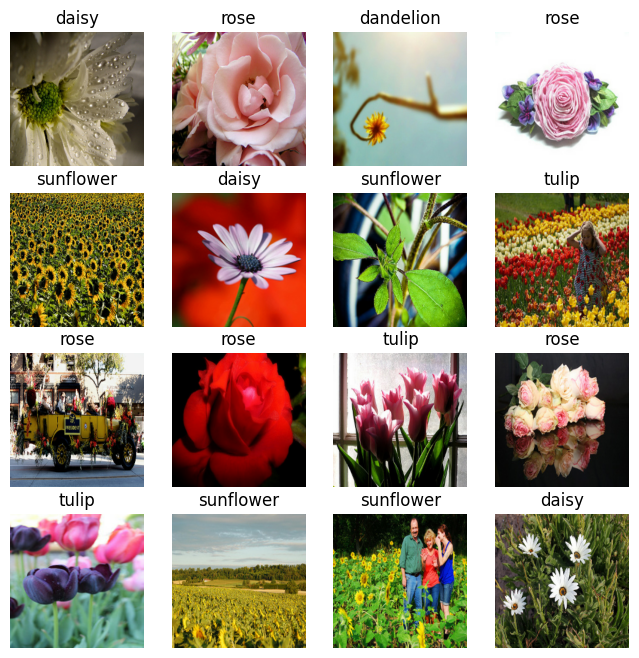

In [9]:
import random
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(images), size=16)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [10]:
# # 이미지 크기를 조정하고 numpy 배열로 변환
# def preprocess_data(dataset):
#     images = []
#     labels = []
#     for example in dataset:
#         image = example['image'].numpy() / 255.0  # 이미지 정규화
#         label = example['label'].numpy()
#         images.append(image)
#         labels.append(label)
#     return np.array(images), np.array(labels)

# train_images, train_labels = preprocess_data(ds_train)

# print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))


In [11]:
# train, test 로 나누기 위해서 슬라이싱

train_images = images[:-600]
train_labels = labels[:-600]
val_images = images[-600 : -300]
val_labels = labels[-600 : -300]
test_images = images[-300:]
test_labels = labels[-300:]


print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(val_images.shape, type(val_images), val_labels.shape, type(val_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

(3070, 224, 224, 3) <class 'numpy.ndarray'> (3070,) <class 'numpy.ndarray'>
(300, 224, 224, 3) <class 'numpy.ndarray'> (300,) <class 'numpy.ndarray'>
(300, 224, 224, 3) <class 'numpy.ndarray'> (300,) <class 'numpy.ndarray'>


In [12]:
# torch tensor로 바꾸고, 모양도 (150, 150, 3) (3, 150, 150) 으로 바꾼다

import torch
train_images = torch.tensor(train_images).permute(0, 3, 1, 2)
val_images = torch.tensor(val_images).permute(0, 3, 1, 2)
test_images = torch.tensor(test_images).permute(0, 3, 1, 2)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

torch.Size([3070, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([3070]) <class 'torch.Tensor'>
torch.Size([300, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([300]) <class 'torch.Tensor'>


In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# CustomDataset 인스턴스 생성
train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)
test_dataset = CustomDataset(test_images, test_labels)

In [14]:
# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader 데이터 확인
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, {type(X)}, {y.dtype}")
    print(f"Shape of y: {y.shape}, {type(y)}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224]), <class 'torch.Tensor'>, torch.int64
Shape of y: torch.Size([64]), <class 'torch.Tensor'>, torch.int64


In [15]:
#########################################################################
#           간단한 훈련 코드
#########################################################################

In [16]:
# # Get cpu, gpu or mps device for training.
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(f"Using {device} device")

# # Define model
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(3*224*224, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 5)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# model = NeuralNetwork().to(device)
# print(model)

In [17]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=2e-6)

In [18]:
# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device).float(), y.to(device)

#         # Compute prediction error
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         if batch % 3 == 0:
#             loss, current = loss.item(), (batch + 1) * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device).float(), y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_loader, model, loss_fn, optimizer)
#     test(test_loader, model, loss_fn)
# print("Done!")

In [21]:
################################################################################
#     복잡한 훈련 코드
################################################################################

In [22]:
# import torch.nn.functional as F

# class NyCNNModel(nn.Module) :
    
#     def __init__(self) :
#         super(NyCNNModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x) :
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [23]:
# class MyCNNModel(nn.Module) :

#     def __init__(self) :
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
#         self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

#         self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.dropout25 = nn.Dropout(p=0.25)
#         self.dropout50 = nn.Dropout(p=0.5)

#         self.fc1 =nn.Linear(7 * 7* 256, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 5)

#     def forward(self, x) :
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pooling(x)
#         x = self.dropout25(x)

#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x= self.pooling(x)
#         x = self.dropout25(x)

#         x = F.relu(self.conv5(x))
#         x = self.pooling(x)
#         x = self.dropout25(x)

#         x = F.relu(self.conv6(x))
#         x = self.pooling(x)
#         x = self.dropout25(x)

#         x = F.relu(self.conv7(x))
#         x = self.pooling(x)
#         x = self.dropout25(x)

#         x = x.view(-1, 7 * 7 * 256)

#         x = F.relu(self.fc1(x))
#         x = self.dropout50(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout50(x)

#         logits = self.fc3(x)

#         return logits
    
# mosel = MyCNNModel().to(device)
# print(model)

In [24]:

# loss_function = torch.nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [25]:
# def model_train(dataloader, model, loss_function, optimizer):

#     model.train()

#     train_loss_sum = train_correct = train_total = 0

#     total_train_batch = len(dataloader)

#     for images, labels in dataloader:

#         x_train = images.to(device)
#         y_train = labels.to(device)

#         outputs = model(x_train)
#         loss = loss_function(outputs, y_train)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss_sum += loss.item()
#         train_total += y_train.size(0)
#         train_correct += (torch.argmax(outputs, dim=1)==y_train).sum().item()

#     train_avg_loss = train_loss_sum / total_train_batch
#     trian_avg_accuracy = train_correct / train_total * 100

#     return train_avg_loss, trian_avg_accuracy


In [26]:
# def model_evaluate(dataloader, model, loss_function, optimizer) :

#     model.eval()

#     with torch.no_grad() : 

#         val_loss_sum = val_correct = total_val = 0
#         total_val_batch = len(dataloader)

#         for images, labels in dataloader :

#             x_val = images.to(device)
#             y_val = labels.to(device)

#             outputs = model(x_val)
#             loss = loss_function(outputs, y_val)

#             val_loss_sum += loss.item()
#             total_val += y_val.size(0)
#             val_correct += (torch.argmax(outputs, dim=1)==y_val).sum().item()

#         val_avg_loss = val_loss_sum / total_val_batch
#         val_avg_accuracy = val_correct / total_val * 100

#         return val_avg_loss, val_avg_accuracy





In [27]:
# from datetime import datetime

# train_loss_list = []
# train_accuracy_list = []

# val_loss_list = []
# val_accuracy_list = []

# start_time = datetime.now()

# EPOCHS = 100

# for epoch in range(EPOCHS):

#     #==============  model train  ================
#     train_avg_loss, train_avg_accuracy = model_train(train_loader, model, loss_function, optimizer)

#     train_loss_list.append(train_avg_loss)
#     train_accuracy_list.append(train_avg_accuracy)
#     #=============================================

#     #============  model evaluation  ==============
#     val_avg_loss, val_avg_accuracy = model_evaluate(test_loader, model, loss_function, optimizer)

#     val_loss_list.append(val_avg_loss)
#     val_accuracy_list.append(val_avg_accuracy)
#     #============  model evaluation  ==============

#     print('epoch:', '%02d' % (epoch + 1),
#           'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
#           'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

# end_time = datetime.now()

# print('elapsed time => ', end_time-start_time)

In [28]:
# def model_test(dataloader, model):

#     model.eval()

#     with torch.no_grad():

#         test_loss_sum = test_correct = test_total = 0

#         total_test_batch = len(dataloader)

#         for images, labels in dataloader:

#             x_test = images.to(device)
#             y_test = labels.to(device)

#             outputs = model(x_test)
#             loss = loss_function(outputs, y_test)

#             test_loss_sum += loss.item()

#             test_total += y_test.size(0)
#             test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

#         test_avg_loss = test_loss_sum / total_test_batch
#         test_avg_accuracy = 100*test_correct / test_total

#         print('accuracy:', test_avg_accuracy)
#         print('loss:', test_avg_loss)

In [29]:
# # test dataset 으로 정확도 및 오차 테스트

# model_test(test_loader, model)

In [30]:
# plt.figure(figsize=(10,5))

# plt.subplot(1,2,1)
# plt.title('Loss Trend')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.grid()
# plt.plot(train_loss_list, label='train')
# plt.plot(val_loss_list, label='validation')
# plt.legend()

# plt.subplot(1,2,2)
# plt.title('Accuracy Trend')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.grid()
# plt.plot(train_accuracy_list, label='train')
# plt.plot(val_accuracy_list, label='validation')
# plt.legend()

# plt.show()

In [31]:
#########################################################################
#            transfer 방식으로
######################################################################

In [32]:
from torchvision import transforms, models

pretrained_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

print(pretrained_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [33]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self, pretrained_model, feature_extractor):

        super().__init__()

        if (feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad = False

        # vision transformer 에서의 classifier 부분은 heads 로 지정
        pretrained_model.heads = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.heads[0].in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 5)
        )

        self.model = pretrained_model

    def forward(self, data):

        logits = self.model(data)

        return logits

In [34]:
feature_extractor = False  # True: Feature Extractor,  False: Fine Tuning

model = MyTransferLearningModel(pretrained_model, feature_extractor).to(device)

print(model)

MyTransferLearningModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
         

In [35]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [36]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(device)
        y_train = labels.to(device)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, dim=1)==y_train).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    trian_avg_accuracy = train_correct / train_total * 100

    return train_avg_loss, trian_avg_accuracy

In [37]:
def model_evaluate(dataloader, model, loss_function, optimizer) :

    model.eval()

    with torch.no_grad() : 

        val_loss_sum = val_correct = total_val = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader :

            x_val = images.to(device)
            y_val = labels.to(device)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            total_val += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1)==y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = val_correct / total_val * 100

        return val_avg_loss, val_avg_accuracy

In [38]:

from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()
EPOCHS = 30

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(val_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


epoch: 01 train loss = 1.582 train acc = 25.668 val loss = 1.554 val acc = 27.333
epoch: 02 train loss = 1.506 train acc = 37.459 val loss = 1.473 val acc = 46.333
epoch: 03 train loss = 1.419 train acc = 49.283 val loss = 1.381 val acc = 57.333
epoch: 04 train loss = 1.322 train acc = 58.111 val loss = 1.275 val acc = 65.000
epoch: 05 train loss = 1.206 train acc = 66.124 val loss = 1.161 val acc = 72.667
epoch: 06 train loss = 1.088 train acc = 72.997 val loss = 1.044 val acc = 82.667
epoch: 07 train loss = 0.983 train acc = 77.720 val loss = 0.931 val acc = 85.333
epoch: 08 train loss = 0.872 train acc = 82.671 val loss = 0.823 val acc = 87.333
epoch: 09 train loss = 0.776 train acc = 85.212 val loss = 0.728 val acc = 89.000
epoch: 10 train loss = 0.695 train acc = 87.068 val loss = 0.650 val acc = 89.000
epoch: 11 train loss = 0.625 train acc = 88.534 val loss = 0.585 val acc = 90.000
epoch: 12 train loss = 0.564 train acc = 90.098 val loss = 0.529 val acc = 90.333
epoch: 13 train 

In [39]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(device)
            y_test = labels.to(device)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [40]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_loader, model)

accuracy: 93.66666666666667
loss: 0.22778311669826506


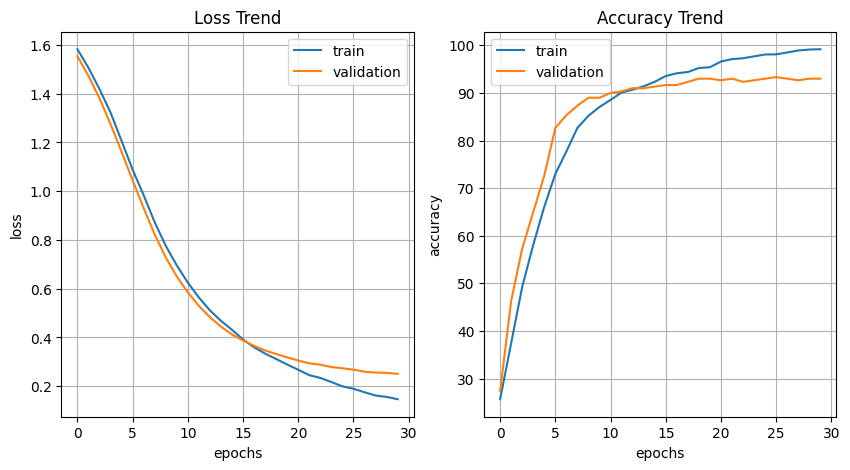

In [41]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()